In [29]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import numpy as np
import time
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
df = pd.read_csv('DelhiDataset.csv',encoding='utf-8')
df.dropna(inplace=True)
df.head(5)

,sl_no,tweet,label
0,1,Traffic coming from Rohini towards Mukundpur...,-1
1,2,so that concerned area traffic staff can be i...,6
2,3,The authority concerned has been given tentat...,-1
3,4,A tree has fallen down at Gate no High Court,-1
4,5,and reach RA Samrat And another rehearsal wil...,-1


In [4]:
Y = df['label']
Y.value_counts()

 0    4831
-1    3459
 2    2821
 3    1487
 1    1156
 6    1001
 4     416
 5     267
Name: label, dtype: int64

Devide Data into Train Test

[Text(0, 0, '-1'),
 Text(1, 0, '0'),
 Text(2, 0, '1'),
 Text(3, 0, '2'),
 Text(4, 0, '3'),
 Text(5, 0, '4'),
 Text(6, 0, '5'),
 Text(7, 0, '6')]

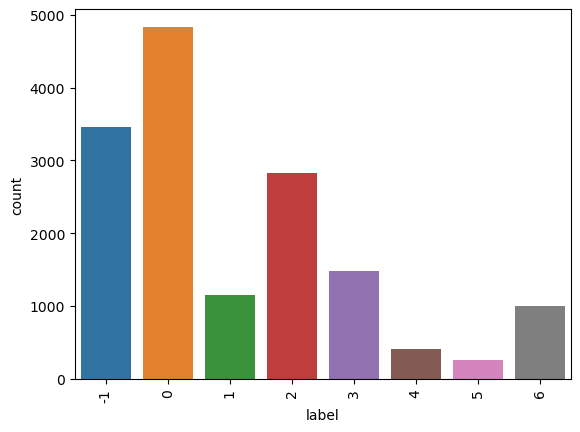

In [5]:
s = sns.countplot(x='label',data=df)
s.set_xticklabels(s.get_xticklabels(),rotation=90)

In [6]:
lb = LabelBinarizer()
y = lb.fit_transform(Y)
y

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df['tweet'],y, stratify=df['label'])
X_train.shape, X_test.shape

((11578,), (3860,))

In [8]:
import pickle
with open('DelhiTrainTestData', 'wb') as file_pi:
    pickle.dump([X_train, X_test, Y_train, Y_test], file_pi)

In [9]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [10]:
def get_sentence_embedding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embedding([
    'Hello My name is Pratik',
    'You have won a lottery! please click the linkn to accept it'
    ])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8533978 , -0.48276782, -0.704772  , ..., -0.6499928 ,
        -0.71603936,  0.8793282 ],
       [-0.7703899 , -0.30926493, -0.23327495, ..., -0.08965112,
        -0.6348652 ,  0.8368935 ]], dtype=float32)>

# BERT Model Configuration

In [11]:
# Bert Layers
text_input_layer = tf.keras.Input(shape=(),dtype=tf.string,name='input')
preprocessed_text_layer = bert_preprocess(text_input_layer)
encoder_layer = bert_encoder(preprocessed_text_layer)

# Neural network layers
n1 = tf.keras.layers.Dropout(0.1,name = 'DropOut')(encoder_layer['pooled_output'])
# n2 = tf.keras.layers.Dense(128, activation='ReLU', name="Dense1")(n1)
output = tf.keras.layers.Dense(len(lb.classes_), activation='softmax', name="Output")(n1)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input_layer], outputs = [output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['input[0][0]']                  
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [12]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training

In [14]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
st = time.time()
epochs = 50
batch_size = 512

checkpoint_path = 'BertDelhi_1/cp-{epoch:03d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=2*batch_size)


# model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     verbose=1,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

# history = model.fit(X_train, y_train, epochs = epochs, batch_size=32)
history = model.fit(X_train, Y_train, epochs = epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001),cp_callback])

et = time.time()
elapsed_time = et - st
print('Execution time: {:0.0f} seconds'.format(elapsed_time))

model.save('Bert_Delhi_model.h5')

import pickle
with open('Bert_Delhi_history', 'wb') as file_pi:
    pickle.dump(history, file_pi)

Epoch 1/50
21/21 [==============================] - 942s 45s/step - loss: 1.8653 - accuracy: 0.2922 - val_loss: 1.6511 - val_accuracy: 0.3670
Epoch 2/50
21/21 [==============================] - 1298s 62s/step - loss: 1.6614 - accuracy: 0.3780 - val_loss: 1.5629 - val_accuracy: 0.4465
Epoch 3/50
21/21 [==============================] - 1294s 62s/step - loss: 1.5723 - accuracy: 0.4393 - val_loss: 1.4932 - val_accuracy: 0.5147
Epoch 4/50
21/21 [==============================] - 1290s 62s/step - loss: 1.5120 - accuracy: 0.4793 - val_loss: 1.4387 - val_accuracy: 0.5155
Epoch 5/50
21/21 [==============================] - 1287s 62s/step - loss: 1.4603 - accuracy: 0.5069 - val_loss: 1.3941 - val_accuracy: 0.5466
Epoch 6/50
21/21 [==============================] - 1298s 62s/step - loss: 1.4077 - accuracy: 0.5229 - val_loss: 1.3556 - val_accuracy: 0.5604
Epoch 7/50
21/21 [==============================] - 1309s 63s/step - loss: 1.3702 - accuracy: 0.5440 - val_loss: 1.3167 - val_accuracy: 0.5656


# Load Model, History and Dataset

In [15]:
# import keras
# model = keras.models.load_model('Bert_delhi_model.h5',custom_objects={'KerasLayer':hub.KerasLayer})

# import pickle
# with open('Bert_delhi_history', "rb") as file_pi:
#     history = pickle.load(file_pi)

# with open('DelhiTrainTestData', 'rb') as file_pi:
#     temp = pickle.load(file_pi)
# X_train = temp[0] 
# X_test = temp[1]
# y_train = temp[2]
# y_test = temp[3]

## Perform on Test Data

In [17]:
print("Accuracy of model on test data : " , model.evaluate(X_test,Y_test)[1]*100 , "%")

121/121 [==============================] - 276s 2s/step - loss: 0.8902 - accuracy: 0.7080
Accuracy of model on test data :  70.80310583114624 %


In [18]:
pred_test = model.predict(X_test)

121/121 [==============================] - 273s 2s/step


## Result Analysis 

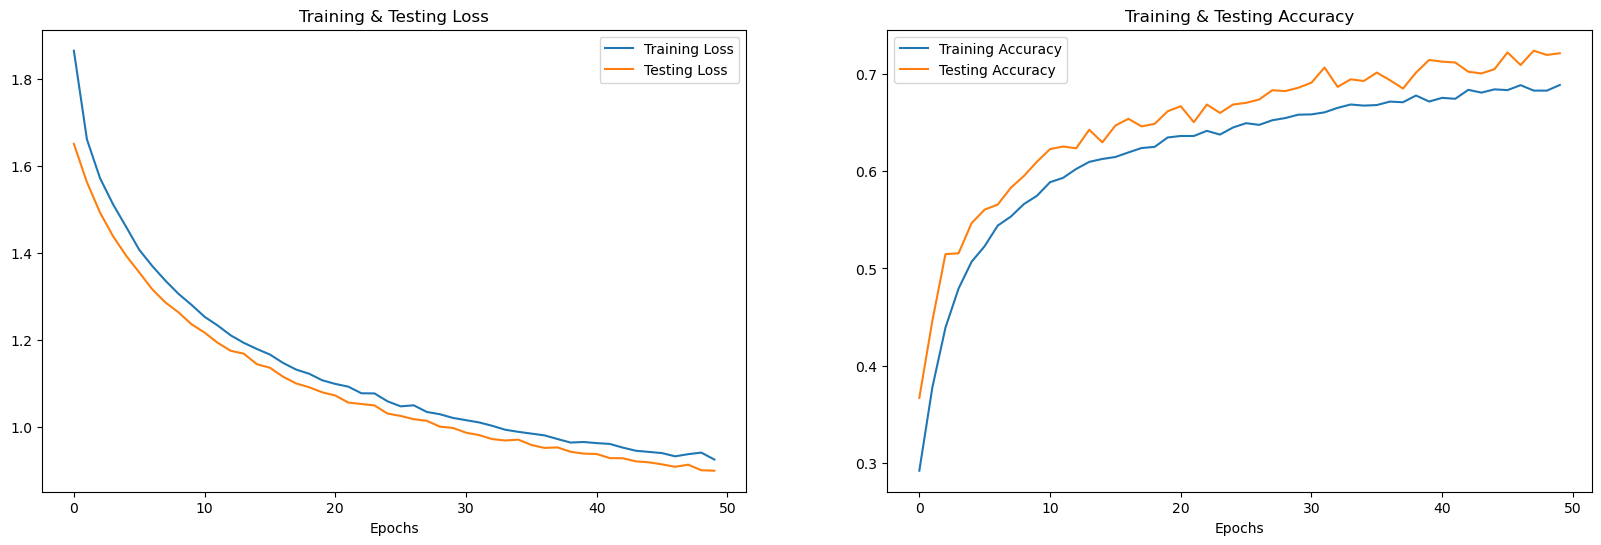

In [20]:
import matplotlib.pyplot as plt

epochList = [i for i in range(len(history.history['loss']))]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochList , train_loss , label = 'Training Loss')
ax[0].plot(epochList , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochList , train_acc , label = 'Training Accuracy')
ax[1].plot(epochList , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [21]:
y_pred = lb.inverse_transform(pred_test)
y_test = lb.inverse_transform(Y_test)

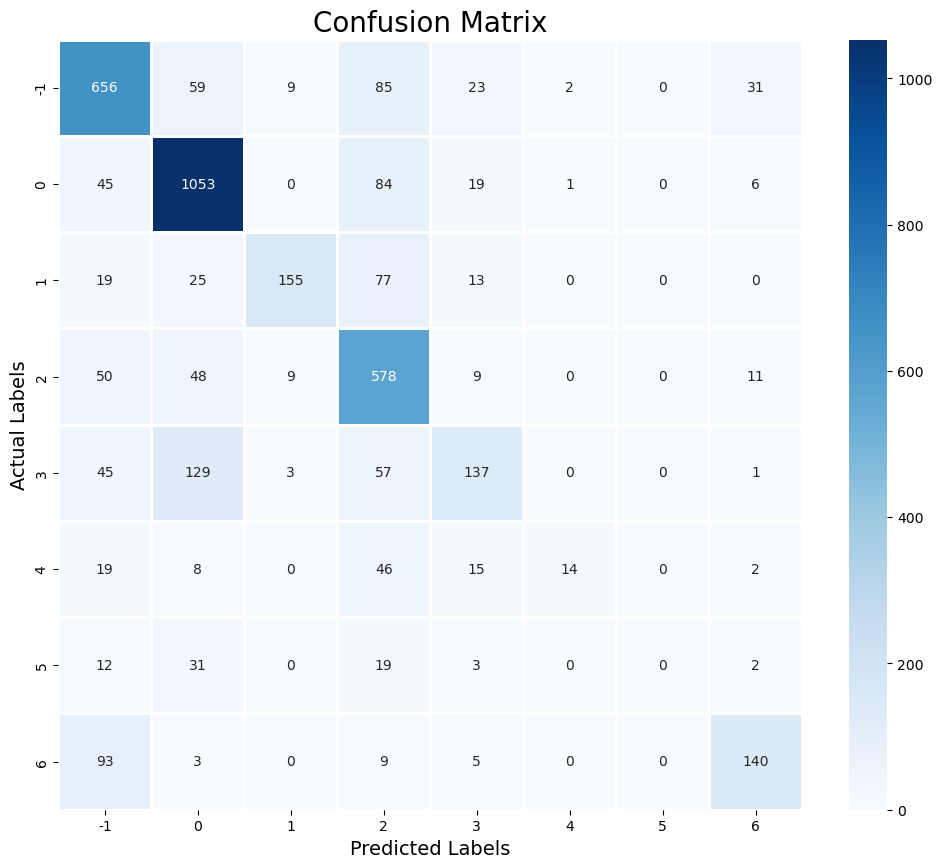

In [22]:
cm = confusion_matrix(y_test, y_pred)
# cm= np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

/tmp/ipykernel_1335463/2080588700.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cm= np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)


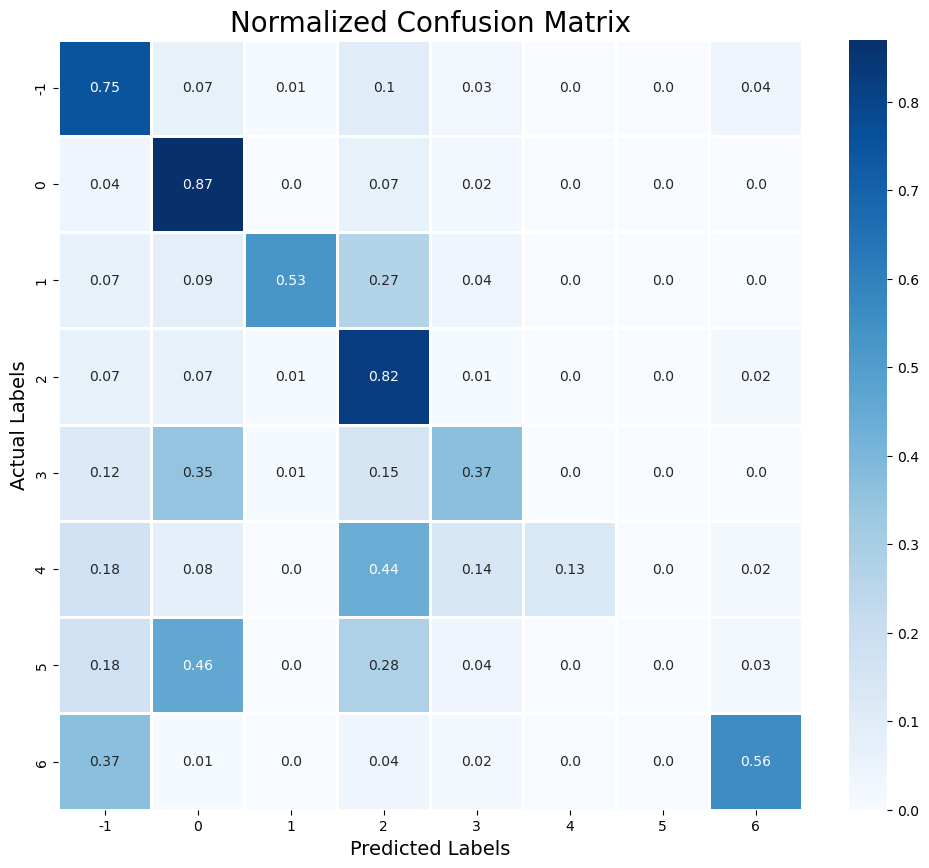

In [24]:
cm = confusion_matrix(y_test, y_pred)
cm= np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Normalized Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.70      0.76      0.73       865
           0       0.78      0.87      0.82      1208
           1       0.88      0.54      0.67       289
           2       0.61      0.82      0.70       705
           3       0.61      0.37      0.46       372
           4       0.82      0.13      0.23       104
           5       0.00      0.00      0.00        67
           6       0.73      0.56      0.63       250

    accuracy                           0.71      3860
   macro avg       0.64      0.51      0.53      3860
weighted avg       0.70      0.71      0.69      3860



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


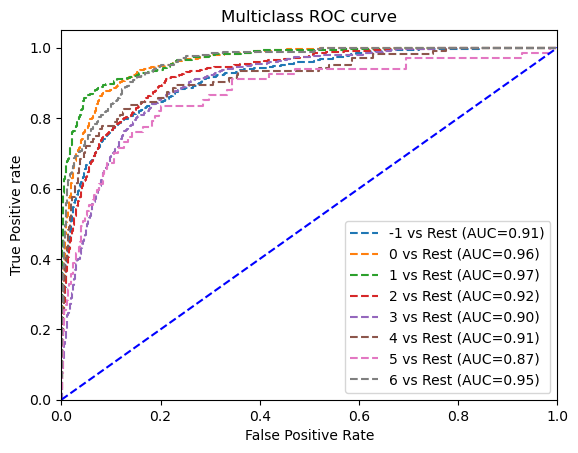

In [26]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve,auc

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

classes = lb.classes_

for i in range(len(classes)):
    # fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test[:,i], pred_test[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # plotting
    plt.plot(fpr[i], tpr[i], linestyle='--',
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

In [27]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, pred_test,multi_class='ovr')
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.9247589474243638


In [28]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore,_  = score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy, precision, recall, fscore, Roc-AUC')
print('{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}'.format(accuracy,precision,recall,fscore,roc_auc))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy, precision, recall, fscore, Roc-AUC
0.708,0.640,0.506,0.529,0.925
